In [5]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv")
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [9]:
#SMA
df_sma = df.copy()
df_sma['4-month-SMA'] = df['Passengers'].rolling(window=4).mean()
df_sma['12-month-SMA'] = df['Passengers'].rolling(window=12).mean()
df_sma.head(10)

,Month,Passengers,4-month-SMA,12-month-SMA
0,1949-01,112,NaN,NaN
1,1949-02,118,NaN,NaN
2,1949-03,132,NaN,NaN
3,1949-04,129,122.75,NaN
4,1949-05,121,125.00,NaN
5,1949-06,135,129.25,NaN
6,1949-07,148,133.25,NaN
7,1949-08,148,138.00,NaN
8,1949-09,136,141.75,NaN
9,1949-10,119,137.75,NaN


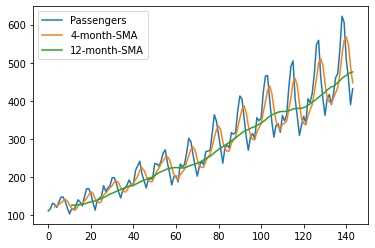

In [10]:
df_sma.plot()

In [13]:
#Simple Exponential Smoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
df_ses = df.copy()

model_ses = SimpleExpSmoothing(df['Passengers'])
fitted_model_ses = model_ses.fit(smoothing_level = 0.3, use_brute = True, optimized = False)
df_ses["alpa_0.3"] = fitted_model_ses.fittedvalues

fitted_model_ses = model_ses.fit(smoothing_level = 0.8, use_brute = True, optimized = False)
df_ses["alpa_0.8"] = fitted_model_ses.fittedvalues

In [14]:
df_ses.head()

,Month,Passengers,alpa_0.3,alpa_0.8
0,1949-01,112,112.000,112.000
1,1949-02,118,112.000,112.000
2,1949-03,132,113.800,116.800
3,1949-04,129,119.260,128.960
4,1949-05,121,122.182,128.992


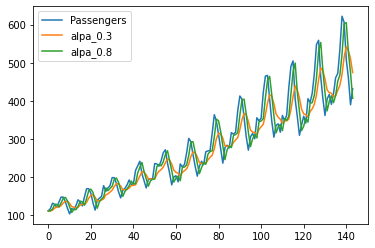

In [15]:
df_ses.plot()

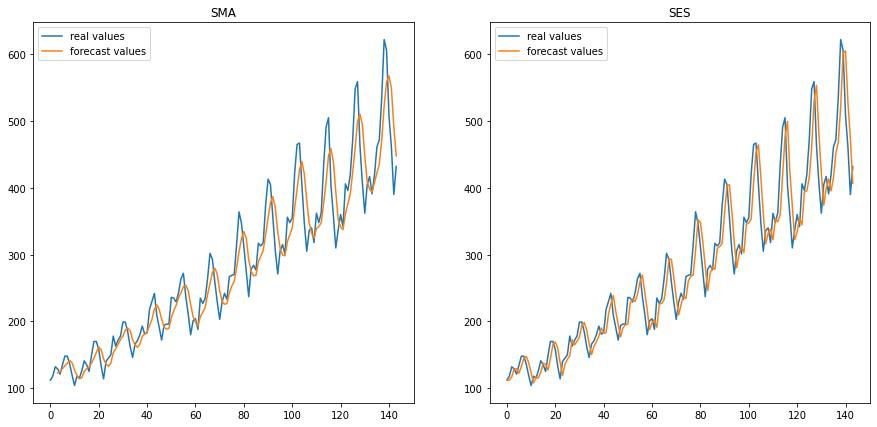

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(15,7)) 


axs[0].plot(df_sma['Passengers'],label='real values')
axs[0].plot(df_sma['4-month-SMA'],label='forecast values')
axs[0].set_title("SMA") 
axs[0].legend()


axs[1].plot(df_ses['Passengers'],label='real values')
axs[1].plot(df_ses['alpa_0.8'],label='forecast values')
axs[1].set_title("SES") 
axs[1].legend()


In [18]:
train_data = df.iloc[:109]
train_data.tail()

,Month,Passengers
104,1957-09,404
105,1957-10,347
106,1957-11,305
107,1957-12,336
108,1958-01,340


In [26]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

train_data = df.iloc[:109]
test_data = df.iloc[109:]

fitted_model = ExponentialSmoothing(train_data['Passengers'], trend='add', seasonal_periods=12, seasonal='add').fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [27]:
test_data.shape

(35, 2)

In [28]:
predict = fitted_model.forecast(60)

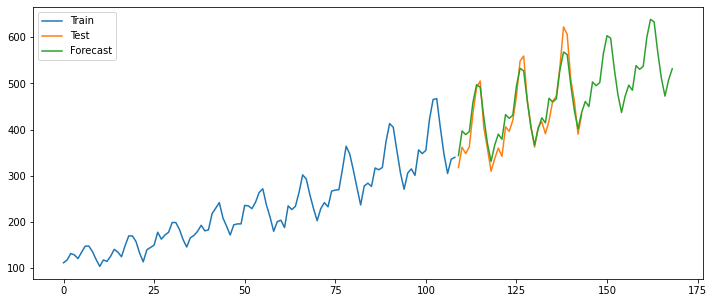

In [29]:
train_data['Passengers'].plot(legend=True, label = 'Train', figsize=(12,5))
test_data['Passengers'].plot(legend=True, label = 'Test')
predict.plot(legend=True, label = "Forecast")

In [31]:
#SARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train_data['Passengers'], seasonal_order=(1,1,1,12))
result = model.fit()

In [36]:
start = len(train_data)
end = len(train_data)+len(test_data)-1

predictions = result.predict(start, end,typ = 'levels').rename("SARIMA forecast")

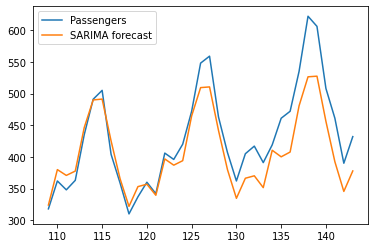

In [37]:
test_data['Passengers'].plot(legend=True)
predictions.plot(legend = True)

In [38]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np 

print("SARIMAX")
print("MAE: ",mean_absolute_error(test_data['Passengers'],predictions))
print("MSE: ",mean_squared_error(test_data['Passengers'],predictions))
print("RMSE: ", np.sqrt(mean_squared_error(test_data['Passengers'],predictions)))
print("R2: ",r2_score(test_data['Passengers'],predictions))
print("")

SARIMAX
MAE:  30.571752934490082
MSE:  1507.400137139718
RMSE:  38.82525128237702
R2:  0.7513748066546322



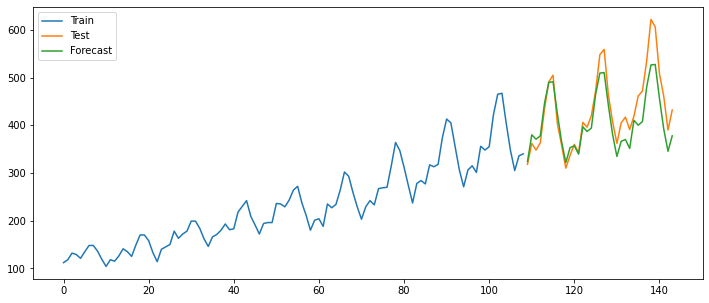

In [39]:
train_data['Passengers'].plot(legend=True, label = 'Train', figsize=(12,5))
test_data['Passengers'].plot(legend=True, label = 'Test')
predictions.plot(legend=True, label = "Forecast")

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


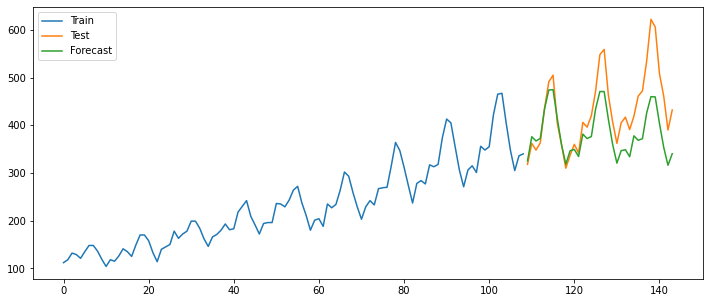

In [40]:
model = SARIMAX(train_data['Passengers'], seasonal_order=(1,0,0,12))
result = model.fit()

start = len(train_data)
end = len(train_data)+len(test_data)-1

predictions = result.predict(start, end,typ = 'levels').rename("SARIMA forecast")

train_data['Passengers'].plot(legend=True, label = 'Train', figsize=(12,5))
test_data['Passengers'].plot(legend=True, label = 'Test')
predictions.plot(legend=True, label = "Forecast")

In [43]:
#Machine Learning Based
df_ml = df.copy()
df_ml = df_ml.drop('Month', axis=1)
df_ml.head()

,Passengers
0,112
1,118
2,132
3,129
4,121


In [44]:
#lagged Function, just copas from 
#https://stackoverflow.com/questions/20410312/how-to-create-a-lagged-data-structure-using-pandas-dataframe
def LaggedFeatures(s,lag=2,fillna=True, dropna=False):
    if type(s) is pd.DataFrame:
        new_dict={}
        for col_name in s:
            new_dict[col_name]=s[col_name]
            # create lagged Series
            for l in range(1,lag+1):
                new_dict['%s_lag%d' %(col_name,l)]=s[col_name].shift(l)
        res=pd.DataFrame(new_dict,index=s.index)

    elif type(s) is pd.Series:
        the_range=range(lag+1)
        res=pd.concat([s.shift(i) for i in the_range],axis=1)
        res.columns=['lag_%d' %i for i in the_range]
    else:
        print ('Only works for DataFrame or Series')
        return None
    if dropna:
        res = res.dropna()
    else:
        res = res
    if fillna:
        return res.fillna(0)
    else:
        return res 

In [45]:
lag_df = LaggedFeatures(df_ml, lag=4, fillna=True, dropna=True)
lag_df.head()

,Passengers,Passengers_lag1,Passengers_lag2,Passengers_lag3,Passengers_lag4
4,121,129.0,132.0,118.0,112.0
5,135,121.0,129.0,132.0,118.0
6,148,135.0,121.0,129.0,132.0
7,148,148.0,135.0,121.0,129.0
8,136,148.0,148.0,135.0,121.0


In [46]:
train = lag_df.iloc[:101]
test = lag_df.iloc[101:]

In [47]:
X_train = train.drop("Passengers", axis=1)
X_test = test.drop("Passengers", axis=1)

y_train = train['Passengers']
y_test = test['Passengers']

X_train = X_train.astype(float).values
y_train = y_train.astype(float).values

X_test = X_test.astype(float).values
y_test = y_test.astype(float).values


In [55]:
#masukkan ke model regresi
from sklearn.svm import SVR #SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import numpy as np

svr = SVR()
rf = RandomForestRegressor()
mlp = MLPRegressor()
lr = LinearRegression()

svr.fit(X_train, y_train)
rf.fit(X_train, y_train)
mlp.fit(X_train, y_train)
lr.fit(X_train, y_train)

LinearRegression()

In [56]:
y_pred_svr = svr.predict(X_test)
y_pred_rf = rf.predict(X_test)
y_pred_mlp = mlp.predict(X_test)
y_pred_lr = lr.predict(X_test)

print("SVR")
print("MAE: ",mean_absolute_error(y_test,y_pred_svr))
print("MSE: ",mean_squared_error(y_test,y_pred_svr))
print("RMSE: ", np.sqrt(mean_squared_error(y_test,y_pred_svr)))
print("R2: ",r2_score(y_test,y_pred_svr))
print("")

print("RF")
print("MAE: ",mean_absolute_error(y_test,y_pred_rf))
print("MSE: ",mean_squared_error(y_test,y_pred_rf))
print("RMSE: ", np.sqrt(mean_squared_error(y_test,y_pred_rf)))
print("R2: ",r2_score(y_test,y_pred_rf))
print("")

print("MLP")
print("MAE: ",mean_absolute_error(y_test,y_pred_mlp))
print("MSE: ",mean_squared_error(y_test,y_pred_mlp))
print("RMSE: ", np.sqrt(mean_squared_error(y_test,y_pred_mlp)))
print("R2: ",r2_score(y_test,y_pred_mlp))
print("")

print("lr")
print("MAE: ",mean_absolute_error(y_test,y_pred_lr))
print("MSE: ",mean_squared_error(y_test,y_pred_lr))
print("RMSE: ", np.sqrt(mean_squared_error(y_test,y_pred_lr)))
print("R2: ",r2_score(y_test,y_pred_lr))
print("")

SVR
MAE:  191.14387223277794
MSE:  43295.76166811409
RMSE:  208.07633615602253
R2:  -5.796539467368585

RF
MAE:  51.318717948717946
MSE:  4665.9706179487175
RMSE:  68.30791036145607
R2:  0.26753907919292186

MLP
MAE:  91.83283756133329
MSE:  13343.636025495238
RMSE:  115.51465718901319
R2:  -1.0946749841398509

lr
MAE:  38.47140678306612
MSE:  2034.0591591497023
RMSE:  45.10054499836673
R2:  0.6806947649957884



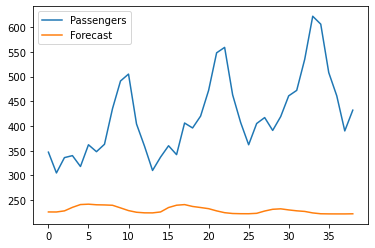

In [63]:
y_test_df = pd.DataFrame(y_test, columns=["Passengers"])
y_pred_svr_df = pd.DataFrame(y_pred_svr, columns=["Forecast"])

y_test_df['Passengers'].plot(legend = True)
y_pred_svr_df['Forecast'].plot(legend = True)

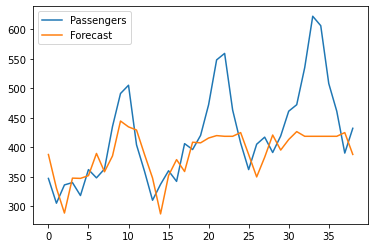

In [64]:
y_test_df = pd.DataFrame(y_test, columns=["Passengers"])
y_pred_rf_df = pd.DataFrame(y_pred_rf, columns=["Forecast"])

y_test_df['Passengers'].plot(legend = True)
y_pred_rf_df['Forecast'].plot(legend = True)

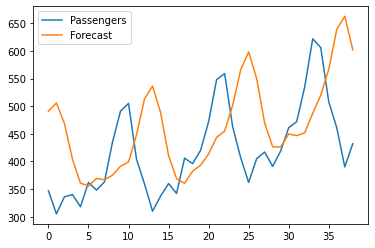

In [65]:
y_test_df = pd.DataFrame(y_test, columns=["Passengers"])
y_pred_mlp_df = pd.DataFrame(y_pred_mlp, columns=["Forecast"])

y_test_df['Passengers'].plot(legend = True)
y_pred_mlp_df['Forecast'].plot(legend = True)

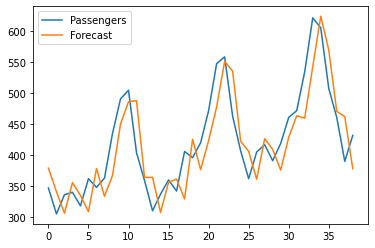

In [66]:
y_test_df = pd.DataFrame(y_test, columns=["Passengers"])
y_pred_lr_df = pd.DataFrame(y_pred_lr, columns=["Forecast"])

y_test_df['Passengers'].plot(legend = True)
y_pred_lr_df['Forecast'].plot(legend = True)